## Introduction
This notebook demonstrates the full interface of the `forecast()` function. 

The best known and most frequent usage of `forecast` enables forecasting on test sets that immediately follows training data. 

However, in many use cases it is necessary to continue using the model for some time before retraining it. This happens especially in **high frequency forecasting** when forecasts need to be made more frequently than the model can be retrained. Examples are in Internet of Things and predictive cloud resource scaling.

Here we show how to use the `forecast()` function when a time gap exists between training data and prediction period.

Terminology:
* forecast origin: the last period when the target value is known
* forecast periods(s): the period(s) for which the value of the target is desired.
* lookback: how many past periods (before forecast origin) the model function depends on. The larger of number of lags and length of rolling window.
* prediction context: `lookback` periods immediately preceding the forecast origin

In [2]:
TIME_COLUMN_NAME = "date"
TIME_SERIES_ID_COLUMN_NAME = "time_series_id"
TARGET_COLUMN_NAME = "y"
lags = [1, 2, 3]
forecast_horizon = 6

### Batch Deployment

In [5]:
import mlflow
import mlflow.sklearn
import pandas as pd

from azure.identity import DefaultAzureCredential
from azure.ai.ml import MLClient
credential = DefaultAzureCredential()
ml_client = None

subscription_id = "<SUBSCRIPTION_ID>"
resource_group = "<RESOURCE_GROUP>"
workspace = "<AML_WORKSPACE_NAME>"

ml_client = MLClient(credential, subscription_id, resource_group, workspace)

# Obtain the tracking URL from MLClient
MLFLOW_TRACKING_URI = ml_client.workspaces.get(
    name=ml_client.workspace_name
).mlflow_tracking_uri

print(MLFLOW_TRACKING_URI)

azureml://eastus.api.azureml.ms/mlflow/v1.0/subscriptions/72c03bf3-4e69-41af-9532-dfcdc3eefef4/resourceGroups/aml-benchmarking/providers/Microsoft.MachineLearningServices/workspaces/aml-benchmarking-rd


In [6]:
from mlflow.tracking.client import MlflowClient
from mlflow.artifacts import download_artifacts

# Set the MLFLOW TRACKING URI
mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)
print("\nCurrent tracking uri: {}".format(mlflow.get_tracking_uri()))

# Initialize MLFlow client
mlflow_client = MlflowClient()


Current tracking uri: azureml://eastus.api.azureml.ms/mlflow/v1.0/subscriptions/72c03bf3-4e69-41af-9532-dfcdc3eefef4/resourceGroups/aml-benchmarking/providers/Microsoft.MachineLearningServices/workspaces/aml-benchmarking-rd


c:\Users\sagoswami\.conda\envs\sdkv2-test1\lib\site-packages\azureml\mlflow\_protos\aml_service_pb2.py:10: UserWarning: google.protobuf.service module is deprecated. RPC implementations should provide code generator plugins which generate code specific to the RPC implementation. service.py will be removed in Jan 2025
  from google.protobuf import service as _service


In [7]:
# job_name = returned_job.name # If training job is in the same notebook
job_name = "yellow_camera_1n84g0vcwp" ## Example of providing an specific Job name/ID

# Get the parent run
mlflow_parent_run = mlflow_client.get_run(job_name)

# print("Parent Run: ")
# print(mlflow_parent_run)

In [8]:
# Get the best model's child run
best_child_run_id = mlflow_parent_run.data.tags["automl_best_child_run_id"]
print("Found best child run id: ", best_child_run_id)

best_run = mlflow_client.get_run(best_child_run_id)

print("Best child run: ")
print(best_run)

Found best child run id:  yellow_camera_1n84g0vcwp_4
Best child run: 
<Run: data=<RunData: metrics={'explained_variance': 0.9910013504019911,
 'mean_absolute_error': 0.29282333566680235,
 'mean_absolute_percentage_error': 1.118067051888466,
 'median_absolute_error': 0.3040329750308685,
 'normalized_mean_absolute_error': 0.011402639389141949,
 'normalized_median_absolute_error': 0.011167830489974646,
 'normalized_root_mean_squared_error': 0.013701302313198613,
 'normalized_root_mean_squared_log_error': 0.00621450456108454,
 'r2_score': 0.9863519731383007,
 'root_mean_squared_error': 0.35499956438249874,
 'root_mean_squared_log_error': 0.01294906396693142,
 'spearman_correlation': 1.0}, params={}, tags={'mlflow.parentRunId': 'yellow_camera_1n84g0vcwp',
 'mlflow.rootRunId': 'yellow_camera_1n84g0vcwp',
 'mlflow.runName': 'ivory_bear_5j8y7myk',
 'mlflow.user': 'Sampurna Goswami',
 'model_explain_run_id': 'yellow_camera_1n84g0vcwp_ModelExplain',
 'model_explanation': 'True'}>, info=<RunInfo:

In [9]:
import datetime
from azure.ai.ml.entities import (
    Environment,
    BatchEndpoint,
    BatchDeployment,
    BatchRetrySettings,
    Model,
)
from azure.ai.ml.constants import BatchDeploymentOutputAction

model_name = "test-batch-endpoint"
batch_endpoint_name = "gap-batch-" + datetime.datetime.now().strftime(
    "%m%d%H%M%f"
)

model = Model(
    path=f"azureml://jobs/{best_run.info.run_id}/outputs/artifacts/outputs/model.pkl",
    name=model_name,
    description="Gap prediction sample best model",
)
registered_model = ml_client.models.create_or_update(model)

env = Environment(
    name="automl-tabular-env",
    description="environment for automl inference",
    image="mcr.microsoft.com/azureml/openmpi4.1.0-ubuntu20.04:latest",
    conda_file="artifact_downloads/outputs/conda_env_v_1_0_0.yml",
)

endpoint = BatchEndpoint(
    name=batch_endpoint_name,
    description="this is a sample batch endpoint",
)
ml_client.begin_create_or_update(endpoint).wait()

In [10]:
from azure.core.exceptions import ResourceNotFoundError
from azure.ai.ml.entities import AmlCompute

cluster_name = "gap-cluster"

try:
    # Retrieve an already attached Azure Machine Learning Compute.
    compute = ml_client.compute.get(cluster_name)
except ResourceNotFoundError as e:
    compute = AmlCompute(
        name=cluster_name,
        size="STANDARD_DS12_V2",
        type="amlcompute",
        min_instances=0,
        max_instances=4,
        idle_time_before_scale_down=120,
    )
    poller = ml_client.begin_create_or_update(compute)
    poller.wait()


In [11]:
batch_endpoint_name

'gap-batch-10282041765753'

In [12]:
output_file = "forecast.csv" # Where the predictions would be stored
batch_deployment = BatchDeployment(
    name="non-mlflow-deployment",
    description="this is a sample non-mlflow deployment",
    endpoint_name=batch_endpoint_name,
    model=registered_model,
    code_path="./forecasting_script",
    scoring_script="forecasting_script.py",
    environment=env,
    environment_variables={
        "TARGET_COLUMN_NAME": TARGET_COLUMN_NAME,
    },
    compute=cluster_name,
    instance_count=1, #2
    max_concurrency_per_instance=1, #2
    mini_batch_size=1, #10
    output_action=BatchDeploymentOutputAction.APPEND_ROW,
    output_file_name=output_file,
    retry_settings=BatchRetrySettings(max_retries=3, timeout=30),
    logging_level="info",
    properties={"include_output_header": "true"},
    tags={"include_output_header": "true"},
)


In [13]:
ml_client.begin_create_or_update(batch_deployment).wait()

Uploading forecasting_script (0.0 MBs): 100%|##########| 2456/2456 [00:01<00:00, 1679.61it/s]




In [46]:
batch_endpoint_name

'gap-batch-10241739762384'

### Data visualization of the train and test data

In [16]:
df_train = pd.read_parquet('./data/training-mltable-folder/df_train.parquet') # We stored the training and test data during training
df_test = pd.read_parquet('./data/testing-mltable-folder/df_test.parquet')

In [17]:
df_train.tail(2)

,date,ext_predictor,time_series_id,y,data_type
58,2000-01-02 04:00:00,70,ts1,33.655695,Training
59,2000-01-02 05:00:00,71,ts1,34.589008,Training


In [19]:
df_test.head(2)

,date,ext_predictor,time_series_id,y,data_type
0,2000-01-02 06:00:00,72,ts0,30.880051,Testing
1,2000-01-02 07:00:00,73,ts0,31.234464,Testing


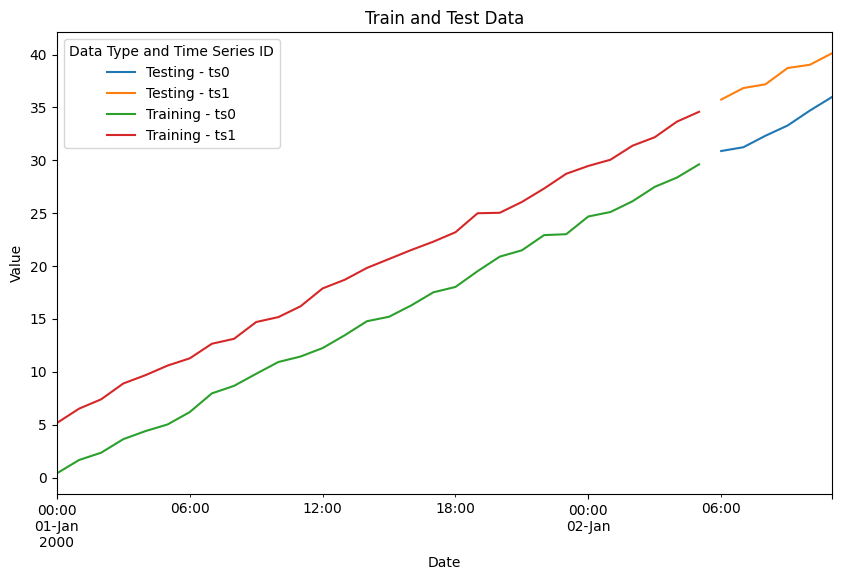

In [20]:
import matplotlib.pyplot as plt
# Concatenate the training and testing DataFrames
df_plot = pd.concat([df_train, df_test])

# Create a figure and axis
plt.figure(figsize=(10, 6))
ax = plt.gca()  # Get current axis

# Group by both 'data_type' and 'time_series_id'
for (data_type, time_series_id), df in df_plot.groupby(['data_type', TIME_SERIES_ID_COLUMN_NAME]):
    df.plot(x='date', y=TARGET_COLUMN_NAME, label=f"{data_type} - {time_series_id}", ax=ax, legend=False)

# Customize the plot
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Train and Test Data')

# Manually create the legend after plotting
plt.legend(title="Data Type and Time Series ID")
plt.show()

# Forecasting from the trained model

In this section we will review the forecast interface for two main scenarios: forecasting right after the training data, and the more complex interface for forecasting when there is a gap (in the time sense) between training and testing data.

## X_train is directly followed by the X_test
Let's first consider the case when the prediction period immediately follows the training data. This is typical in scenarios where we have the time to retrain the model every time we wish to forecast. Forecasts that are made on daily and slower cadence typically fall into this category. Retraining the model every time benefits the accuracy because the most recent data is often the most informative.


<img src="./images/forecast_function_at_train.png" alt="Description" width="50%">

We use X_test as a forecast request to generate the predictions.

### Get the test data for which we need the prediction

In [22]:
from azure.ai.ml import Input
from azure.ai.ml.constants import AssetTypes
my_test_data_input = Input(
    type=AssetTypes.URI_FOLDER,
    path="./data/test_data_scenarios",
)

In [23]:
my_test_data_input

{'type': 'uri_folder', 'path': './data/test_data_scenarios'}

### Invoke the endpoint with the test data

In [54]:
# import os
# os.system("az login")

# def refresh_token():
#     os.system("az account get-access-token")

# Call refresh_token() at regular intervals in your notebook, if necessary


In [27]:
job = ml_client.batch_endpoints.invoke(
    endpoint_name=batch_endpoint_name,
    input=my_test_data_input, #Test data input
    deployment_name="non-mlflow-deployment",  # name is required as default deployment is not set
)

In [28]:
job_name = job.name
batch_job = ml_client.jobs.get(name=job_name)
print(batch_job.status)
# stream the job logs
ml_client.jobs.stream(name=job_name)

Running
RunId: batchjob-45f67a27-5f29-4582-8388-be8d180658dd
Web View: https://ml.azure.com/runs/batchjob-45f67a27-5f29-4582-8388-be8d180658dd?wsid=/subscriptions/72c03bf3-4e69-41af-9532-dfcdc3eefef4/resourcegroups/aml-benchmarking/workspaces/aml-benchmarking-rd

Streaming logs/azureml/executionlogs.txt

[2024-10-28 15:27:46Z] Submitting 1 runs, first five are: 7805450f:d9e63b6f-d1a4-4419-b3ac-87f8e334da18
[2024-10-28 15:34:03Z] Completing processing run id d9e63b6f-d1a4-4419-b3ac-87f8e334da18.

Execution Summary
RunId: batchjob-45f67a27-5f29-4582-8388-be8d180658dd
Web View: https://ml.azure.com/runs/batchjob-45f67a27-5f29-4582-8388-be8d180658dd?wsid=/subscriptions/72c03bf3-4e69-41af-9532-dfcdc3eefef4/resourcegroups/aml-benchmarking/workspaces/aml-benchmarking-rd



In [33]:
job_name," ", output_file

('batchjob-45f67a27-5f29-4582-8388-be8d180658dd', ' ', 'forecast.csv')

In [36]:
# Get the predictions
download_path = "./outputs/"
ml_client.jobs.download(job_name, download_path=download_path)

In [38]:
fcst_df = pd.read_csv(download_path + output_file, parse_dates=[TIME_COLUMN_NAME])
fcst_df.head()

,date,ext_predictor,time_series_id,data_type,y,prediction_interval,predicted
0,2000-01-02 06:00:00,72,ts0,Testing,30.880051,"[30.07023297694423, 30.938095002841163]",30.504164
1,2000-01-02 07:00:00,73,ts0,Testing,31.234464,"[30.948404564288648, 32.04935617279979]",31.498880
2,2000-01-02 08:00:00,74,ts0,Testing,32.324927,"[32.30731438581761, 32.679879108573864]",32.493597
3,2000-01-02 09:00:00,75,ts0,Testing,33.290239,"[33.18813407978154, 33.78849217191297]",33.488313
4,2000-01-02 10:00:00,76,ts0,Testing,34.696732,"[34.06278818141216, 34.90327082758539]",34.483030


# Forecasting away from training data
Suppose we trained a model, some time passed, and now we want to apply the model without re-training. If the model "looks back" -- uses previous values of the target -- then we somehow need to provide those values to the model.

<img src="./images/forecast_function_away_from_train.png" alt="Description" width="50%">

The notion of forecast origin comes into play: **the forecast origin is the last period for which we have seen the target value.** This applies per time-series, so each time-series can have a different forecast origin.

The part of data before the forecast origin is the **prediction context**. To provide the context values the model needs when it looks back, we pass definite values in y_test (aligned with corresponding times in X_test).

In [44]:
# Generate the same kind of test data we trained on, but now make the train set much longer, so that the test set will be in the future
from helper import get_timeseries, make_forecasting_query
X_context, y_context, X_away, y_away = get_timeseries(
    train_len=42,  # train data was 30 steps long
    test_len=4,
    time_column_name=TIME_COLUMN_NAME,
    target_column_name=TARGET_COLUMN_NAME,
    time_series_id_column_name=TIME_SERIES_ID_COLUMN_NAME,
    time_series_number=2,
)

print("End of the data we trained on:")
print(df_train.groupby(TIME_SERIES_ID_COLUMN_NAME)[TIME_COLUMN_NAME].max())

print("\nStart of the data we want to predict on:")
print(X_away.groupby(TIME_SERIES_ID_COLUMN_NAME)[TIME_COLUMN_NAME].min())

End of the data we trained on:
time_series_id
ts0   2000-01-02 05:00:00
ts1   2000-01-02 05:00:00
Name: date, dtype: datetime64[ns]

Start of the data we want to predict on:
time_series_id
ts0   2000-01-02 18:00:00
ts1   2000-01-02 18:00:00
Name: date, dtype: datetime64[ns]


c:\Users\sagoswami\projects\2024\forecast_notebooks\azureml-examples\sdk\python\jobs\automl-standalone-jobs\automl-forecasting-forecast-function\helper.py:39: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  time_column_name: pd.date_range(


There is a gap of 12 hours between end of training and beginning of X_away. (It looks like 13 because all timestamps point to the start of the one hour periods.) Using only X_away will fail without adding context data for the model to consume

In [52]:
x_gap_test = X_away.copy()
x_gap_test["y"] = y_away
x_gap_test['data_type'] = 'test'  # Dummy data

x_gap_test.to_csv("./data/test_gap_scenario/gap_test_data.csv")

In [57]:
my_test_data_gap_input = Input(
    type=AssetTypes.URI_FOLDER,
    path="./data/test_gap_scenario/",  # Path to the data folder that has the test data with gap
)

In [60]:
gap_job = ml_client.batch_endpoints.invoke(
    endpoint_name=batch_endpoint_name,
    input=my_test_data_gap_input, #Test data input
    deployment_name="non-mlflow-deployment",  # name is required as default deployment is not set
)

In [61]:
job_name = gap_job.name
batch_job = ml_client.jobs.get(name=job_name)
print(batch_job.status)
# stream the job logs
ml_client.jobs.stream(name=job_name)

Running
RunId: batchjob-291ce8ee-cff0-49f2-9335-107e2472fc65
Web View: https://ml.azure.com/runs/batchjob-291ce8ee-cff0-49f2-9335-107e2472fc65?wsid=/subscriptions/72c03bf3-4e69-41af-9532-dfcdc3eefef4/resourcegroups/aml-benchmarking/workspaces/aml-benchmarking-rd

Streaming logs/azureml/executionlogs.txt

[2024-10-28 18:28:54Z] Submitting 1 runs, first five are: 7805450f:418b0b81-c680-48f7-be2c-22e8add701f6
[2024-10-28 18:37:22Z] Completing processing run id 418b0b81-c680-48f7-be2c-22e8add701f6.

Execution Summary
RunId: batchjob-291ce8ee-cff0-49f2-9335-107e2472fc65
Web View: https://ml.azure.com/runs/batchjob-291ce8ee-cff0-49f2-9335-107e2472fc65?wsid=/subscriptions/72c03bf3-4e69-41af-9532-dfcdc3eefef4/resourcegroups/aml-benchmarking/workspaces/aml-benchmarking-rd



In [62]:
# Get the predictions
gap_download_path = "./outputs/gap_scenario/"
ml_client.jobs.download(job_name, download_path=gap_download_path)

In [63]:
gap_fcst_df = pd.read_csv(gap_download_path + output_file, parse_dates=[TIME_COLUMN_NAME])
gap_fcst_df.head()

,Unnamed: 0,date,ext_predictor,time_series_id,data_type,y,prediction_interval,predicted
0,42,2000-01-02 18:00:00,84,ts0,test,42.253241,"[42.00682831806445, 42.87469034396139]",42.440759
1,43,2000-01-02 19:00:00,85,ts0,test,43.126377,"[42.884999905408854, 43.98595151391999]",43.435476
2,44,2000-01-02 20:00:00,86,ts0,test,44.532234,"[44.2439097269378, 44.61647444969405]",44.430192
3,45,2000-01-02 21:00:00,87,ts0,test,45.489004,"[45.124729420901716, 45.725087513033145]",45.424908
4,42,2000-01-02 18:00:00,84,ts1,test,47.127495,"[37.27487135377912, 38.14273337967606]",37.708802


In [70]:
gap_fcst_df['data_type']="gap_forecast"

# Local inferencing from model pickle


1. **Model**  
   We will need the MLflow model, which is downloaded at the end of the training notebook. Follow any training notebook to get the model. The MLflow model is usually downloaded to the folder: `./artifact_downloads/outputs/mlflow-model`.

2. **Environment**  
   We will need the environment to load the model. Please run the following commands to create the environment (the conda file is usually downloaded to: `./artifact_downloads/outputs/mlflow-model/conda.yaml`):
   - `conda env create --file <path_to_conda_yaml>`
   - `conda activate project_environment`

3. **Register environment as kernel**  
   - Please run the following command to register the environment as a kernel:  
     ```bash
     python -m ipykernel install --user --name project_environment --display-name "model-inference"
     ```
   - Refresh the kernel and then select the newly created kernel named `model-inference` from the kernel dropdown.
   
   Now we are good to run this notebook in the newly created kernel.

In [3]:
import mlflow.pyfunc
import mlflow.sklearn
# Please ensure that the training artifacts are downloaded. For more details refer to the training notebook
mlflow_dir = "./artifact_downloads/outputs/mlflow-model"
fitted_model = mlflow.sklearn.load_model(mlflow_dir)

ModuleNotFoundError: No module named 'azureml.training'

In [ ]:
df_train[df_train['time_series_id']=="ts1"].tail(2)

In [ ]:
df_test[df_test['time_series_id']=="ts1"].head(2)

# Forecasting from the trained model

In this section we will review the forecast interface for two main scenarios: forecasting right after the training data, and the more complex interface for forecasting when there is a gap (in the time sense) between training and testing data.

## X_train is directly followed by the X_test
Let's first consider the case when the prediction period immediately follows the training data. This is typical in scenarios where we have the time to retrain the model every time we wish to forecast. Forecasts that are made on daily and slower cadence typically fall into this category. Retraining the model every time benefits the accuracy because the most recent data is often the most informative.


<img src="./images/forecast_function_at_train.png" alt="Description" width="50%">

We use X_test as a forecast request to generate the predictions.

In [ ]:
X_test = df_test.copy()
y_test = X_test.pop(TARGET_COLUMN_NAME).values.astype(float)

y_pred_no_gap, xy_nogap = fitted_model.forecast(X_test)

### Confidence Intervals
Forecasting model may be used for the prediction of forecasting intervals by running forecast_quantiles(). This method accepts the same parameters as forecast().

In [ ]:
quantiles = fitted_model.forecast_quantiles(X_test)
quantiles

### Distribution forecasts
Often the figure of interest is not just the point prediction, but the prediction at some quantile of the distribution. This arises when the forecast is used to control some kind of inventory, for example of grocery items or virtual machines for a cloud service. In such case, the control point is usually something like "we want the item to be in stock and not run out 99% of the time". This is called a "service level". Here is how you get quantile forecasts.

In [ ]:
# Specify which quantiles you would like
fitted_model.quantiles = [0.01, 0.5, 0.95]

# use forecast_quantiles function, not the forecast() one
y_pred_quantiles = fitted_model.forecast_quantiles(X_test)

# quantile forecasts returned in a Dataframe along with the time and time series id columns
y_pred_quantiles

# Forecasting away from training data
Suppose we trained a model, some time passed, and now we want to apply the model without re-training. If the model "looks back" -- uses previous values of the target -- then we somehow need to provide those values to the model.

<img src="./images/forecast_function_away_from_train.png" alt="Description" width="50%">

The notion of forecast origin comes into play: **the forecast origin is the last period for which we have seen the target value.** This applies per time-series, so each time-series can have a different forecast origin.

The part of data before the forecast origin is the **prediction context**. To provide the context values the model needs when it looks back, we pass definite values in y_test (aligned with corresponding times in X_test).

In [ ]:
# generate the same kind of test data we trained on, but now make the train set much longer, so that the test set will be in the future
from helper import get_timeseries, make_forecasting_query
X_context, y_context, X_away, y_away = get_timeseries(
    train_len=42,  # train data was 30 steps long
    test_len=4,
    time_column_name=TIME_COLUMN_NAME,
    target_column_name=TARGET_COLUMN_NAME,
    time_series_id_column_name=TIME_SERIES_ID_COLUMN_NAME,
    time_series_number=2,
)

print("End of the data we trained on:")
print(df_train.groupby(TIME_SERIES_ID_COLUMN_NAME)[TIME_COLUMN_NAME].max())

print("\nStart of the data we want to predict on:")
print(X_away.groupby(TIME_SERIES_ID_COLUMN_NAME)[TIME_COLUMN_NAME].min())

There is a gap of 12 hours between end of training and beginning of X_away. (It looks like 13 because all timestamps point to the start of the one hour periods.) Using only X_away will fail without adding context data for the model to consume

In [ ]:
try:
    y_pred_away, xy_away = fitted_model.forecast(X_away)
    xy_away
except Exception as e:
    print(e)

How should we read that eror message? The forecast origin is at the last time the model saw an actual value of y (the target). That was at the end of the training data! The model is attempting to forecast from the end of training data. But the requested forecast periods are past the forecast horizon. We need to provide a define y value to establish the forecast origin.

We will use the helper function to take the required amount of context from the data preceding the testing data. It's definition is intentionally simplified to keep the idea in the clear.

Let's see where the context data ends - it ends, by construction, just before the testing data starts.

In [ ]:
print(
    X_context.groupby(TIME_SERIES_ID_COLUMN_NAME)[TIME_COLUMN_NAME].agg(
        ["min", "max", "count"]
    )
)
print(
    X_away.groupby(TIME_SERIES_ID_COLUMN_NAME)[TIME_COLUMN_NAME].agg(
        ["min", "max", "count"]
    )
)
X_context.tail(5)

How should we read that eror message? The forecast origin is at the last time the model saw an actual value of y (the target). That was at the end of the training data! The model is attempting to forecast from the end of training data. But the requested forecast periods are past the forecast horizon. We need to provide a define y value to establish the forecast origin.

We will use this helper function to take the required amount of context from the data preceding the testing data. It's definition is intentionally simplified to keep the idea in the clear.

In [ ]:
# Since the length of the lookback is 3, we need to add 3 periods from the context to the request so that the model has the data it needs

# Put the X and y back together for a while. They like each other and it makes them happy.
X_context[TARGET_COLUMN_NAME] = y_context
X_away[TARGET_COLUMN_NAME] = y_away
fulldata = pd.concat([X_context, X_away])

# Forecast origin is the last point of data, which is one 1-hr period before test
forecast_origin = X_away[TIME_COLUMN_NAME].min() - pd.DateOffset(hours=1)
# it is indeed the last point of the context
assert forecast_origin == X_context[TIME_COLUMN_NAME].max()
print("Forecast origin: " + str(forecast_origin))

# The model uses lags and rolling windows to look back in time
n_lookback_periods = max(lags) # n_lookback_periods = max(max(lags), forecast_horizon) # If target_rolling_window_size is used
lookback = pd.DateOffset(hours=n_lookback_periods)
horizon = pd.DateOffset(hours=forecast_horizon)

In [ ]:
# now make the forecast query from context (refer to figure)
X_pred, y_pred = make_forecasting_query(
    fulldata, TIME_COLUMN_NAME, TARGET_COLUMN_NAME, forecast_origin, horizon, lookback
)

# show the forecast request aligned
X_show = X_pred.copy()
X_show[TARGET_COLUMN_NAME] = y_pred
X_show[X_show['time_series_id']=="ts0"]

In [ ]:
X_pred['data_type']="unknown"   # Our trining had an additional column called data_type, hence, adding it

In [ ]:
# Now everything should work
y_pred_away, xy_away = fitted_model.forecast(X_pred, y_pred)

# show the forecast aligned without the generated features
X_show = xy_away.reset_index()
X_show[["date", "time_series_id", "ext_predictor", "_automl_target_col"]] # prediction is in _automl_target_col

In [ ]:
### Let us look at the tail of training data and the head of the test data for one grain

In [ ]:
df_train[df_train['time_series_id']=="ts1"].tail(2)

If there is a gap between the train and the test data, and the test data uses lags/ rolling forecasts, we need to append the context data such that the test data has access to the lags
In the above case, train_data ends at 2000-01-02 05:00:00

In [ ]:
X_show[X_show['time_series_id'] == "ts1"][["date", "time_series_id", "ext_predictor", "_automl_target_col"]]